# Import Data

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import time
import warnings
from lifelines import KaplanMeierFitter
warnings.filterwarnings('ignore')

This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

In [69]:
df = pd.read_csv('data/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data Exploration

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There is no column with null values and duplications

In [71]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [72]:
df.duplicated().sum()

0

In [73]:
def categorize_variable(df, drop_cols = None):
    if drop_cols is not None:
        df = df.drop(columns=drop_cols)
        
    # Initial type-based split
    num_cols = df.select_dtypes('number').columns.tolist()
    cat_cols = df.select_dtypes('object').columns.tolist()
    
    # col names, unique values, data type, values
    num_updated_cols = []
    cat_updated_cols = []
    col_names = []
    unique_values = []
    data_type = []
    values = []
    for col in num_cols + cat_cols: 
        if df[col].nunique() < 10:
            cat_updated_cols.append(col) 
            col_names.append(col)
            unique_values.append(df[col].nunique())
            data_type.append('categorical')
            values.append(df[col].unique())
        else:
            num_updated_cols.append(col)
            col_names.append(col)
            unique_values.append(df[col].nunique())
            data_type.append('numerical')    
            values.append('')
    data = pd.DataFrame({
        'Column Name': col_names,
        'Unique Values': unique_values,
        'Data Type': data_type,
        'Values': values
    })
    
    try:
        from IPython.display import display
        display(data.style.background_gradient(cmap='viridis'))
    except:
        print(data)
        
    print('==== initial categorication ====')             
    print('Numerical columns:', num_cols)
    print('Categorical columns:', cat_cols)
    print('==== updated categorication ====')   
    print('Numerical columns:', num_updated_cols)
    print('Categorical columns:', cat_updated_cols)          

    
    return num_updated_cols, cat_updated_cols

In [74]:
num_cols, cat_cols = categorize_variable(df, drop_cols = ['RowNumber', 'CustomerId', 'Surname'])

,Column Name,Unique Values,Data Type,Values
0,CreditScore,460,numerical,
1,Age,70,numerical,
2,Tenure,11,numerical,
3,Balance,6382,numerical,
4,NumOfProducts,4,categorical,[1 3 2 4]
5,HasCrCard,2,categorical,[1 0]
6,IsActiveMember,2,categorical,[1 0]
7,EstimatedSalary,9999,numerical,
8,Exited,2,categorical,[1 0]
9,Geography,3,categorical,['France' 'Spain' 'Germany']


==== initial categorication ====
Numerical columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Categorical columns: ['Geography', 'Gender']
==== updated categorication ====
Numerical columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
Categorical columns: ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', 'Geography', 'Gender']


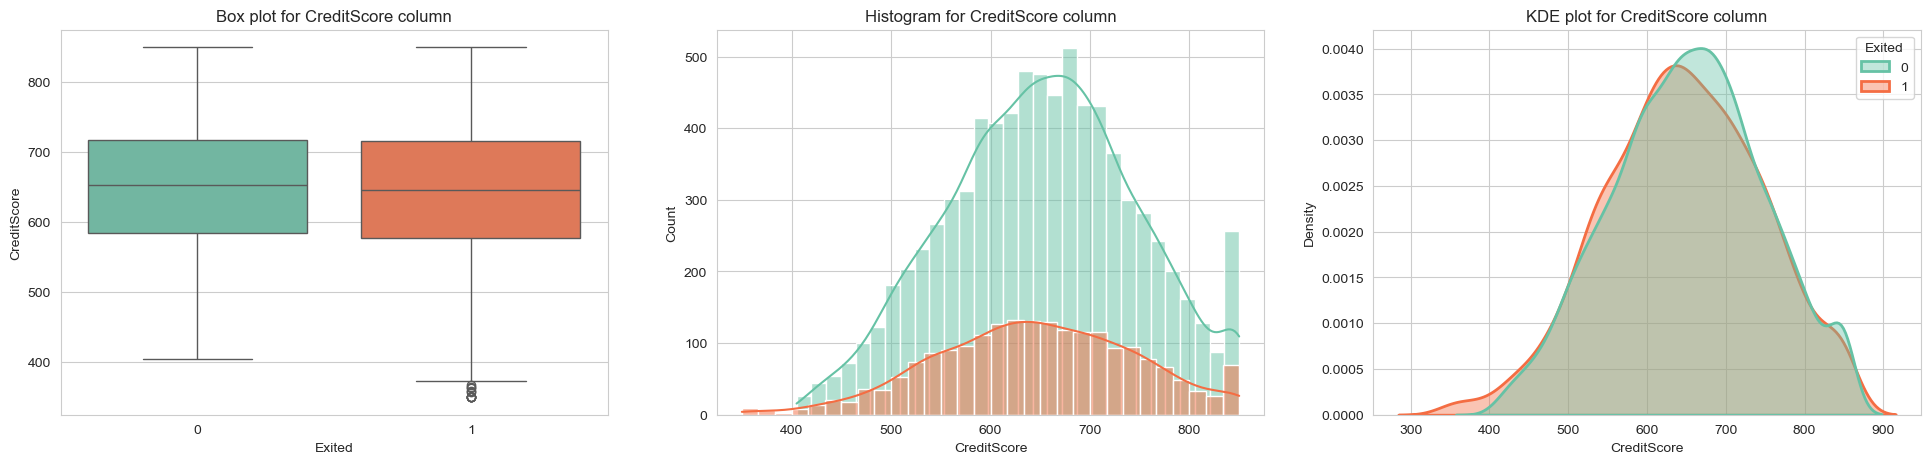

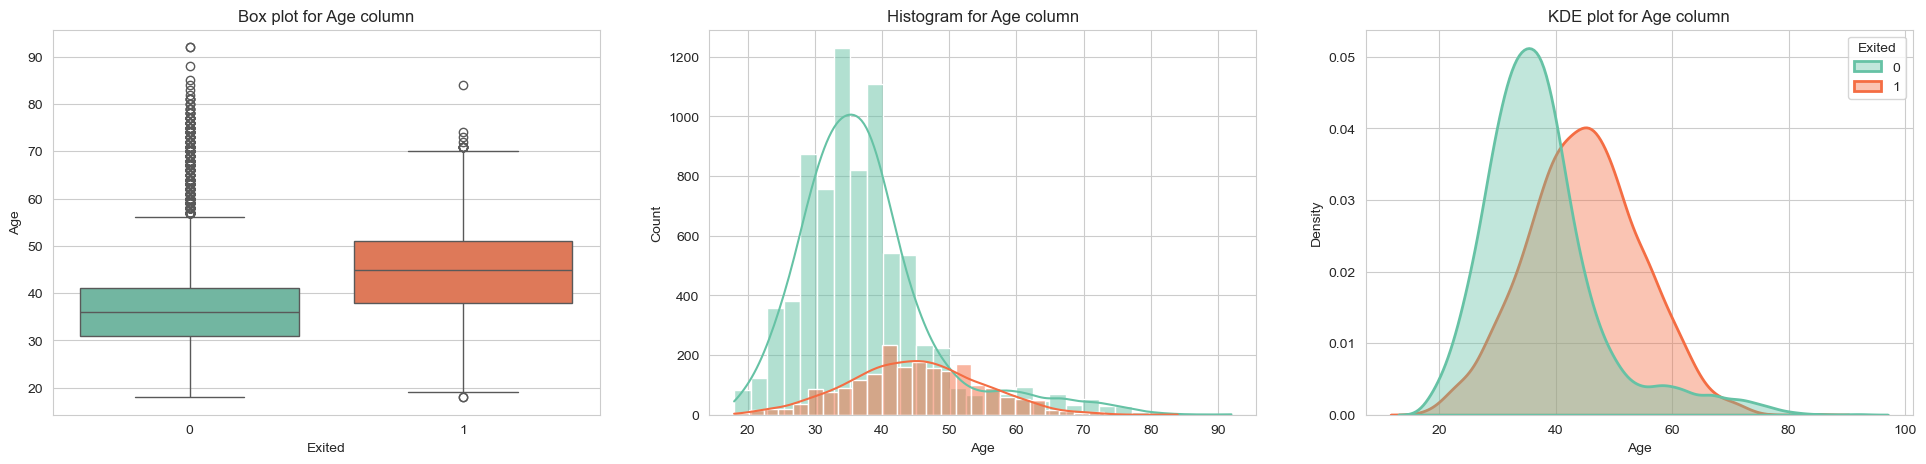

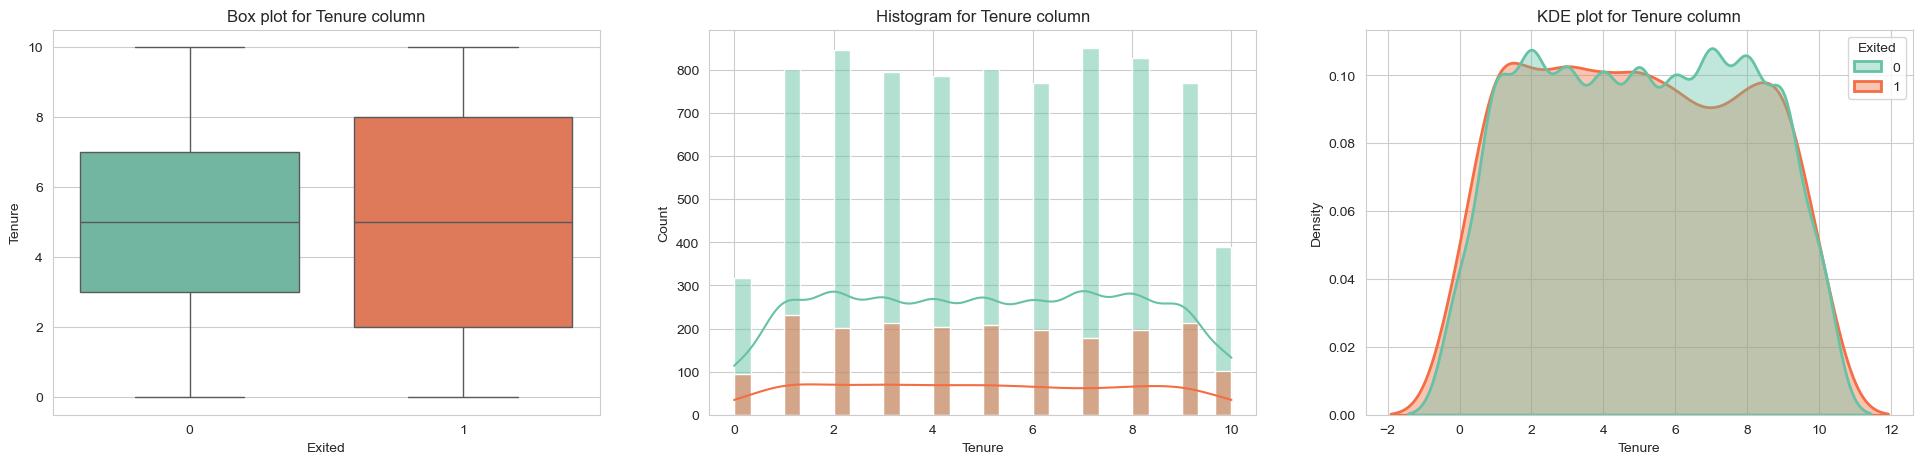

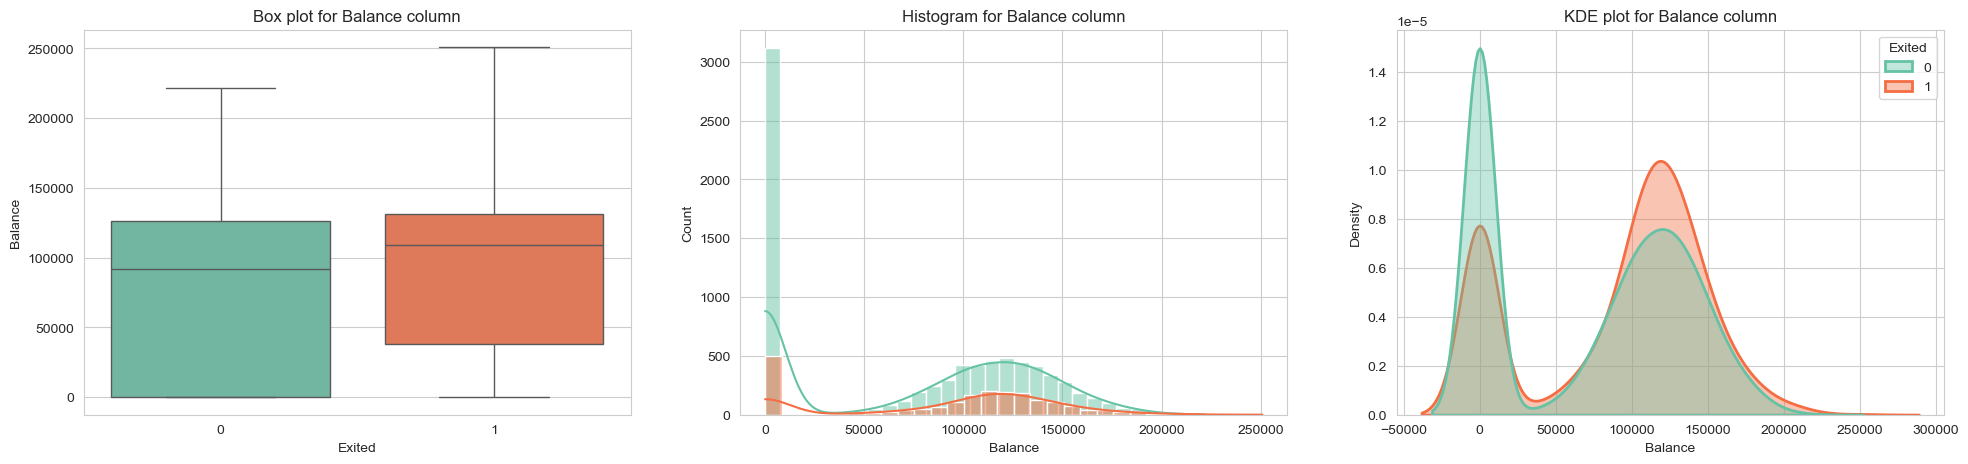

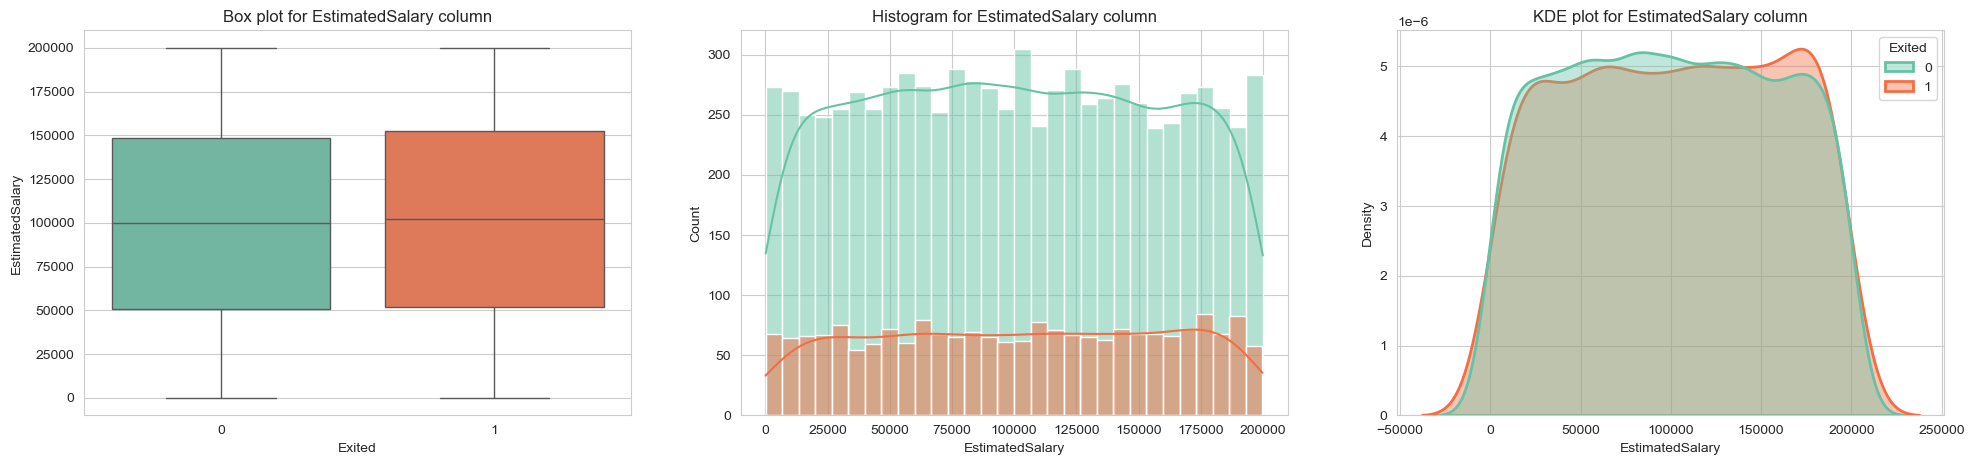

In [75]:
for num in num_cols:
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 3, figsize=(24, 5))
    
    # ---------------------
    # 1. Box plot by exited
    # ---------------------
    not_churn = '#66C2A5'
    churned = '#F46D43'
    box_palette = {'0': not_churn, '1': churned}
    box_palette2 = {0: not_churn, 1: churned}
    sns.boxplot(ax=axes[0], data=df, x='Exited', y= num,  palette = box_palette)
    title_box = f"Box plot for {num} column"
    axes[0].set_title("\n".join(textwrap.wrap(title_box, width=50)))
    
    # ---------------------
    # 2. Histogram by exited
    # ---------------------
    sns.histplot(ax=axes[1], data=df[df['Exited']== 0], x=num, color= not_churn, kde=True, bins=30)
    sns.histplot(ax=axes[1], data=df[df['Exited']== 1], x=num, color= churned, kde=True, bins=30)
    title_hist = f"Histogram for {num} column"
    axes[1].set_title("\n".join(textwrap.wrap(title_hist, width=50)))
    
    # ---------------------
    # 3. KDE plot by exited
    # ---------------------
    sns.kdeplot(ax=axes[2], data=df, x=num, hue="Exited", fill=True, common_norm=False,
                alpha=0.4, linewidth=2, palette= box_palette2)
    title_kde = f"KDE plot for {num} column"
    axes[2].set_title("\n".join(textwrap.wrap(title_kde, width=50)))
     
    
    

<Axes: >

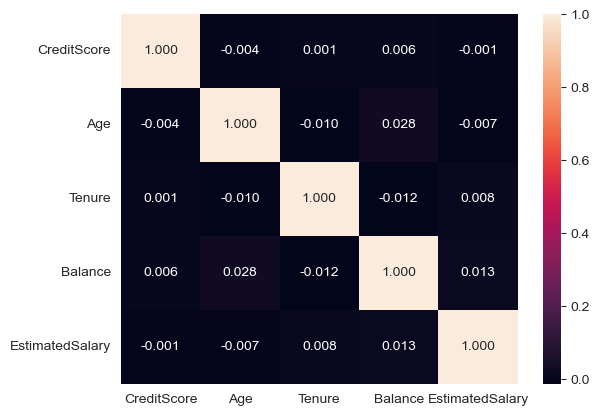

In [76]:
sns.heatmap(df[num_cols].corr(), annot= True, fmt='.3f')

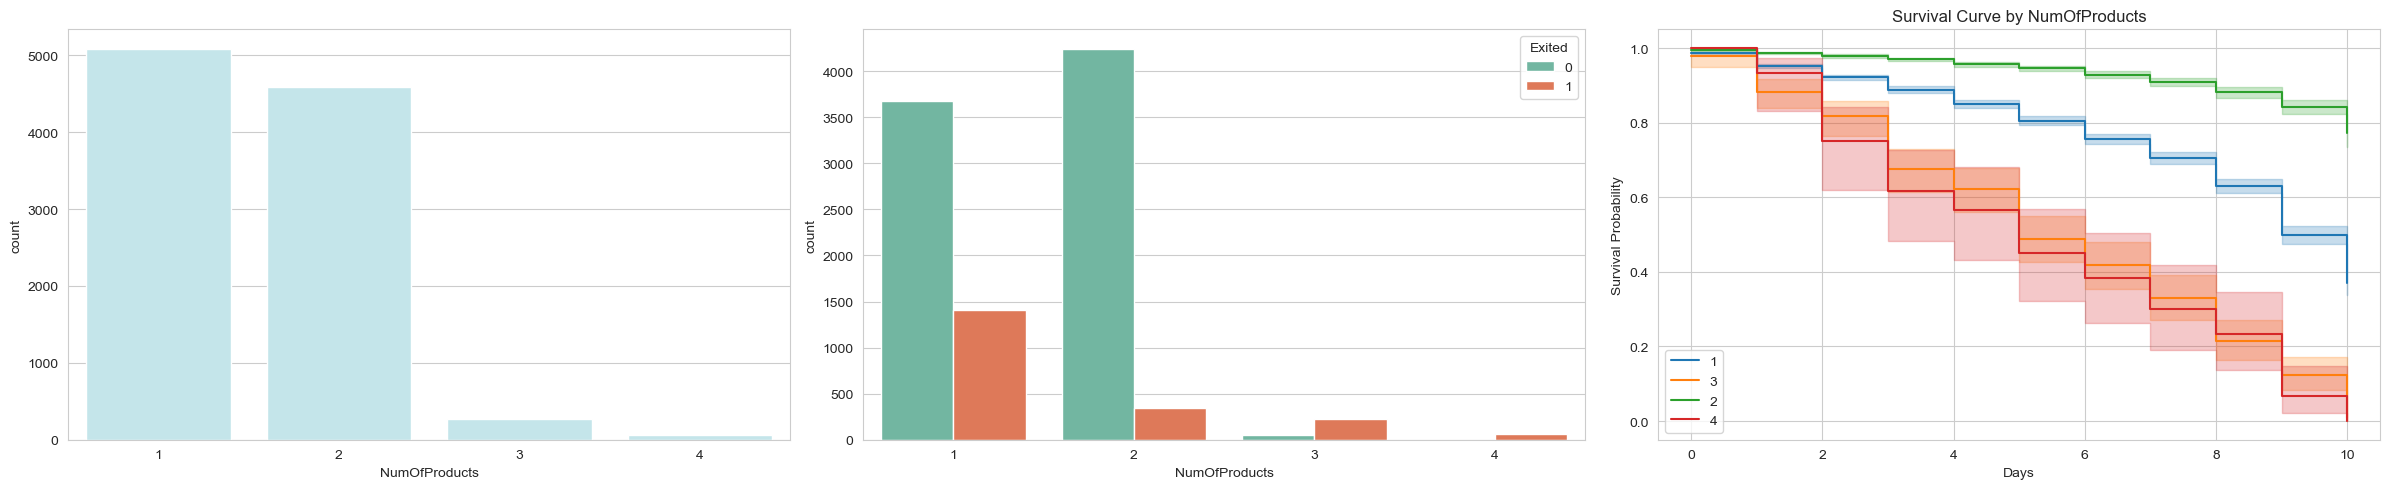

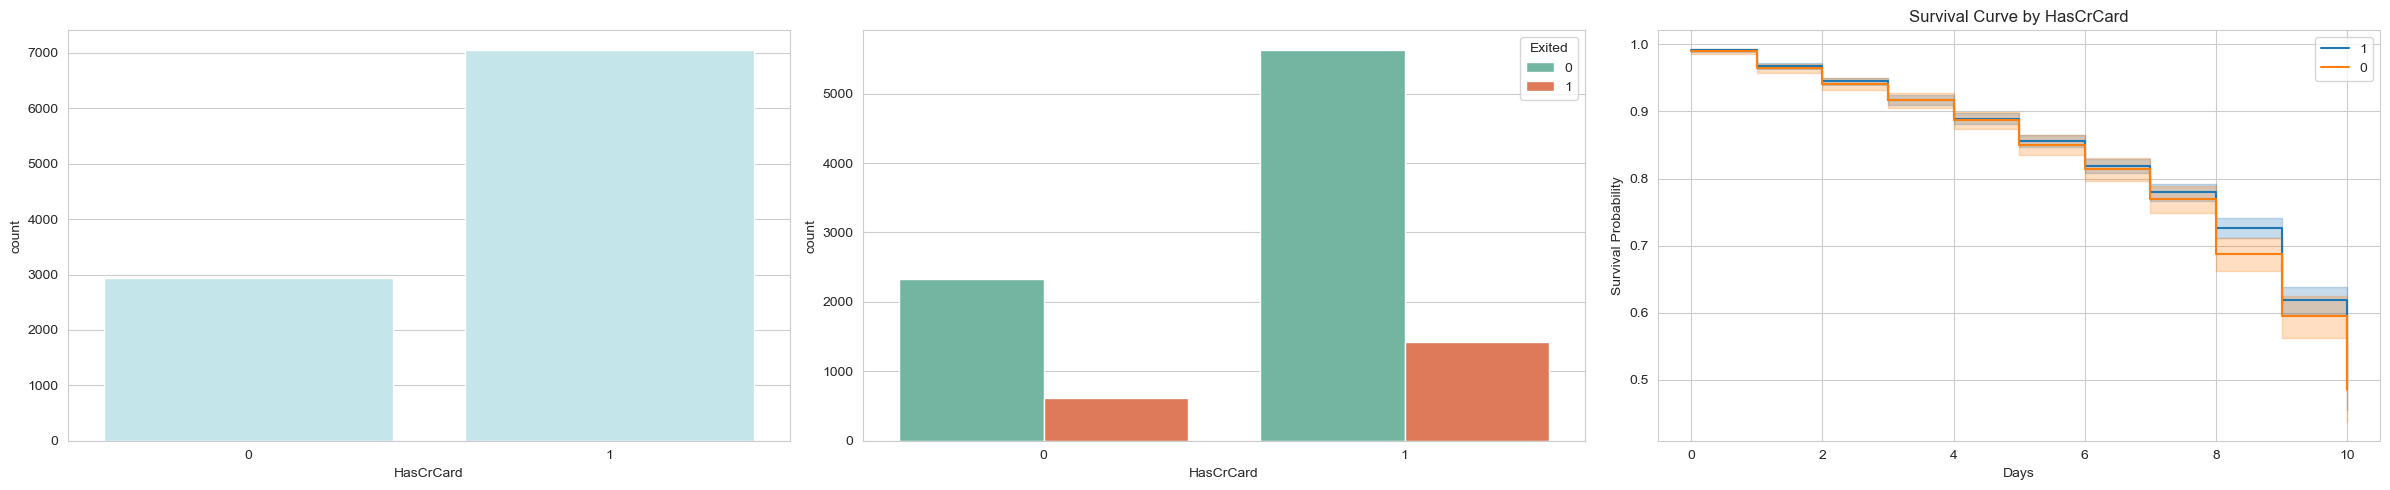

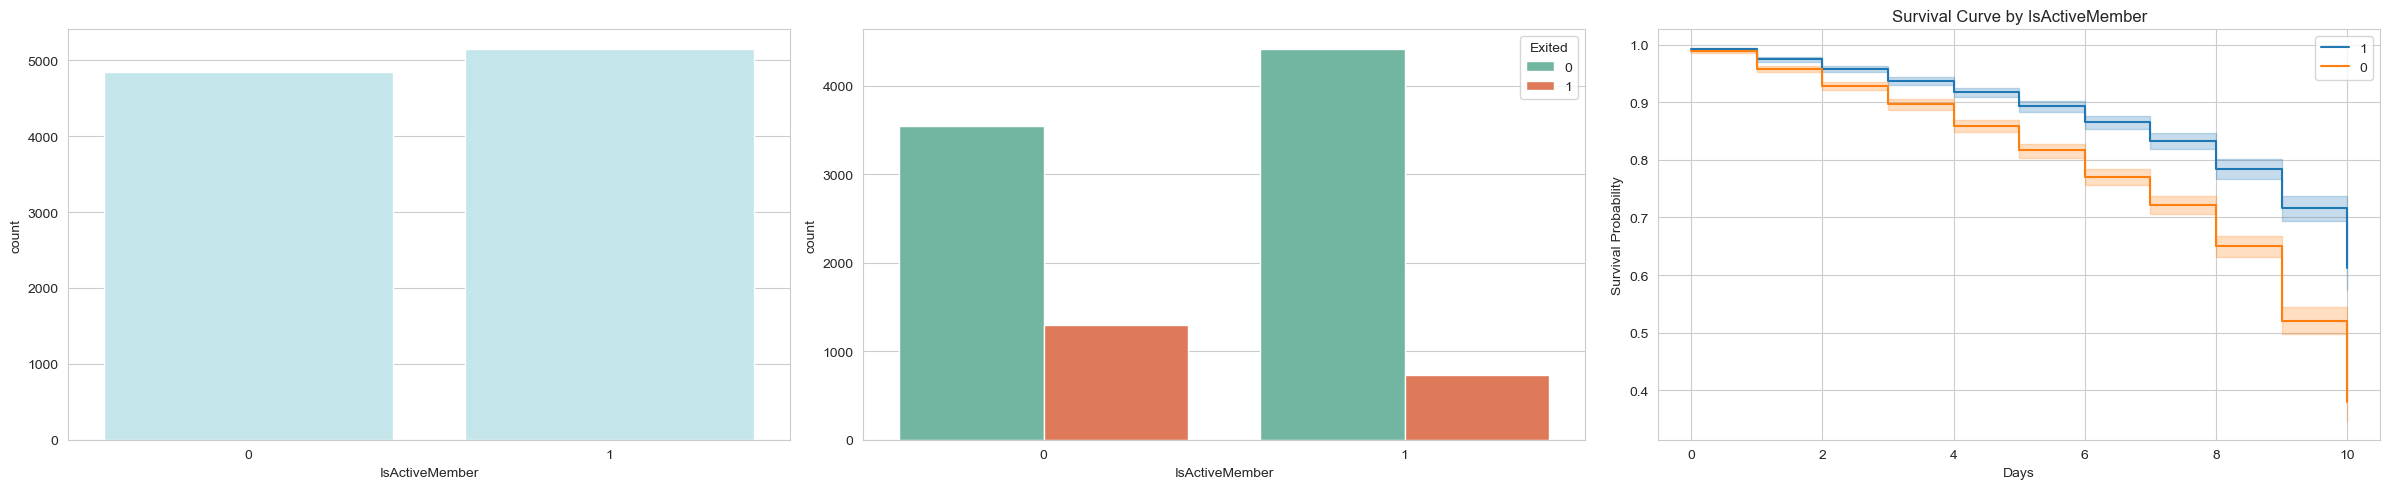

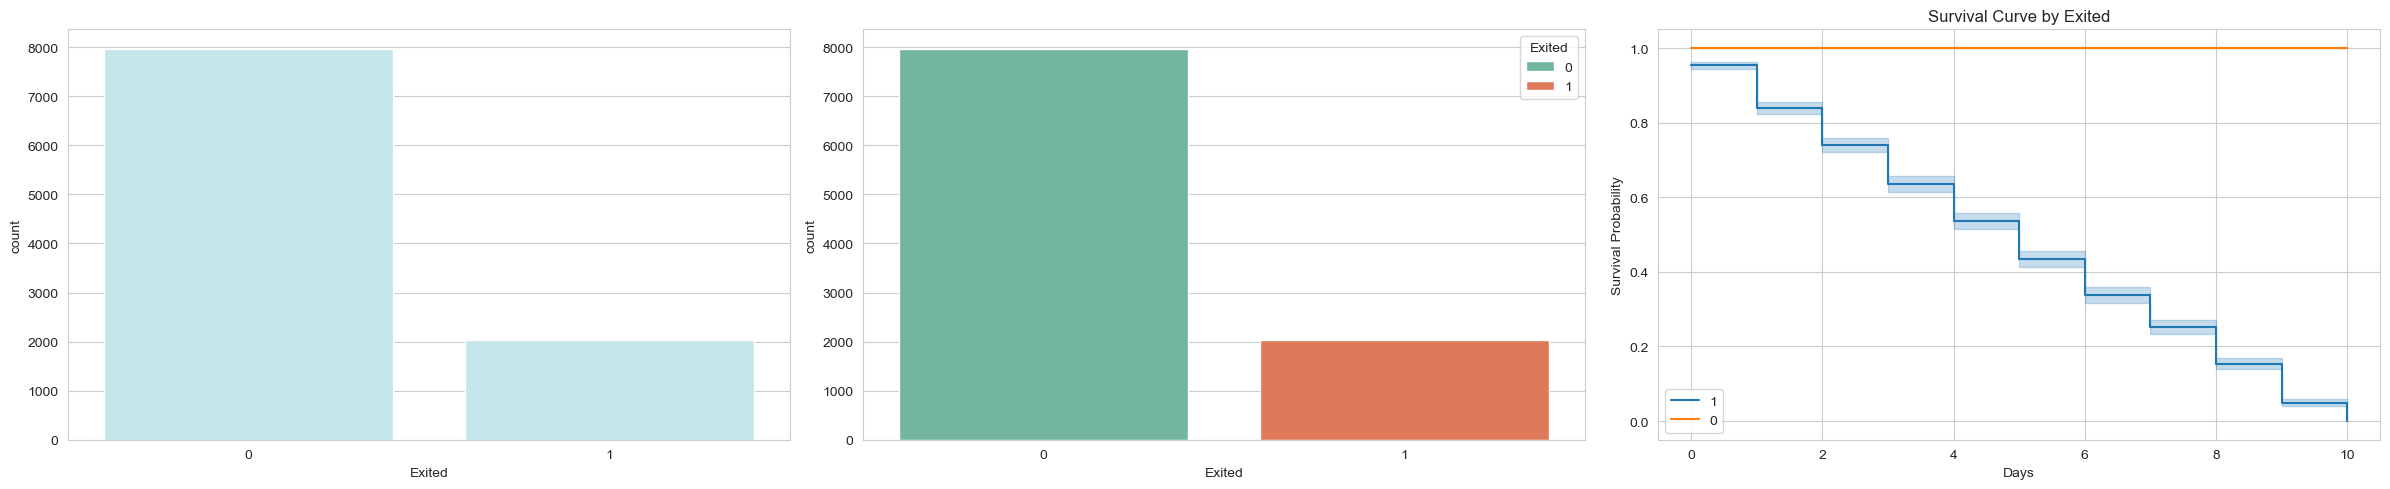

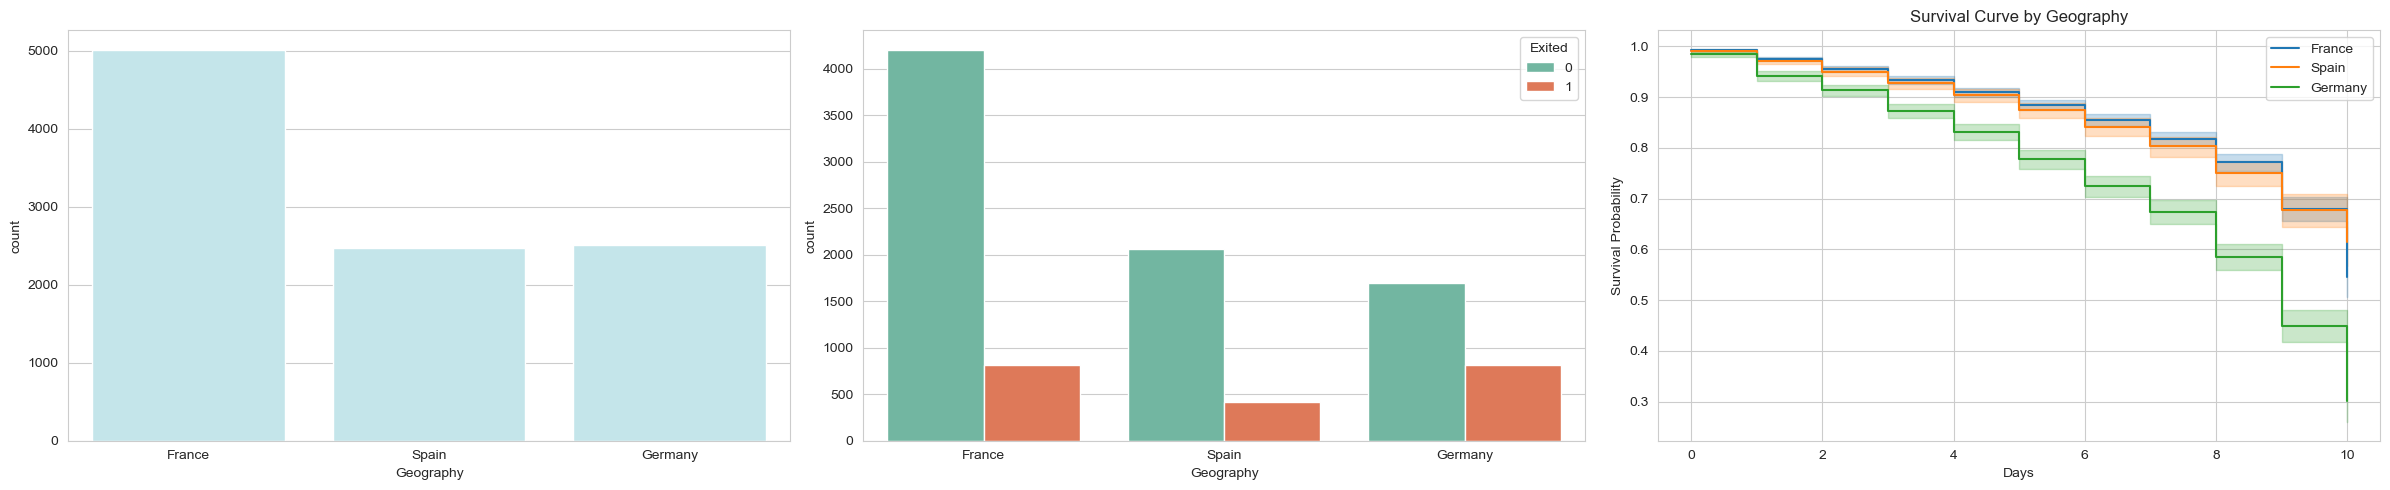

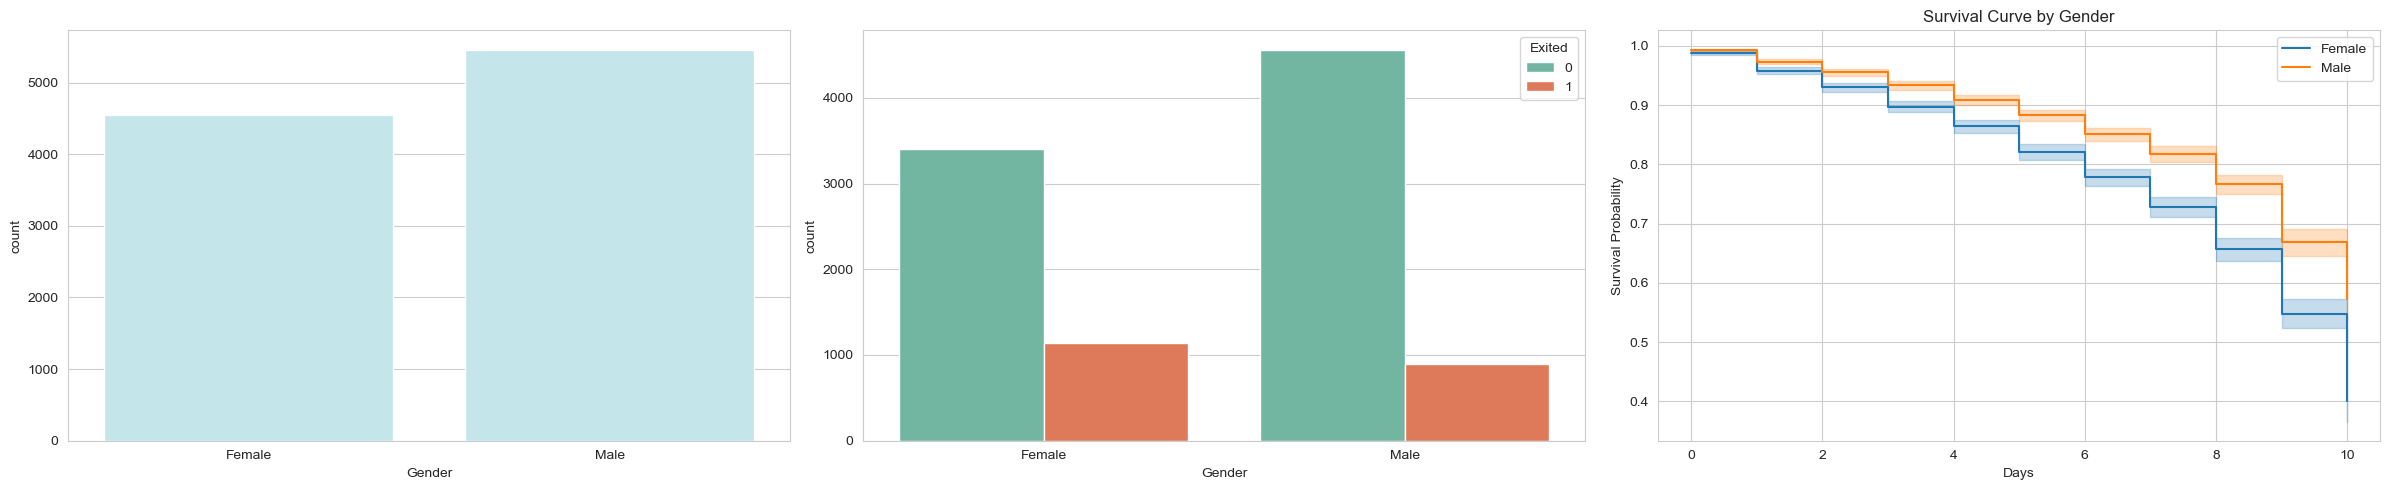

In [77]:
for num in cat_cols:
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 3, figsize=(24, 5))
    
    # ---------------------
    # 1. Count plot
    # ---------------------
    sns.countplot(ax=axes[0], data = df, x = num, color = '#beeaf0')
    

    # ---------------------
    # 2. Count plot by group
    # ---------------------
    box_palette = {0: not_churn, 1: churned}
    sns.countplot(ax=axes[1], data = df, x = num, hue = 'Exited', palette=box_palette)
    
    
     # ---------------------
    # 2. Survival probability by group
    # ---------------------
    for group in df[num].unique():
        mask = df[num] == group
        kmf.fit(df['Tenure'][mask], event_observed=df['Exited'][mask], label=str(group))
        kmf.plot_survival_function(ax=axes[2])
    
    axes[2].set_title(f"Survival Curve by {num}")
    axes[2].set_xlabel("Days")
    axes[2].set_ylabel("Survival Probability")

    plt.tight_layout()
    plt.show()
    
    

# Survival model

## Feature engineering

In [ ]:
# standardize data
for col in num_cols:
    df[f'{col}_log'] = np.log(df[col]+1)

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_log,Age_log,Tenure_log,Balance_log,EstimatedSalary_log
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,6.429719,3.761200,1.098612,0.000000,11.526334
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,6.411818,3.737670,0.693147,11.336294,11.631096
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,6.220590,3.761200,2.197225,11.980813,11.643362
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,6.551080,3.688879,0.693147,0.000000,11.449215
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,6.746412,3.784190,1.098612,11.740155,11.278280


In [79]:
# one-hot encoding
df = pd.get_dummies(df, columns = cat_cols, drop_first=True) 
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,EstimatedSalary,CreditScore_log,Age_log,...,EstimatedSalary_log,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1,IsActiveMember_1,Exited_1,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,Hargrave,619,42,2,0.00,101348.88,6.429719,3.761200,...,11.526334,False,False,False,True,True,True,False,False,False
1,2,15647311,Hill,608,41,1,83807.86,112542.58,6.411818,3.737670,...,11.631096,False,False,False,False,True,False,False,True,False
2,3,15619304,Onio,502,42,8,159660.80,113931.57,6.220590,3.761200,...,11.643362,False,True,False,True,False,True,False,False,False
3,4,15701354,Boni,699,39,1,0.00,93826.63,6.551080,3.688879,...,11.449215,True,False,False,False,False,False,False,False,False
4,5,15737888,Mitchell,850,43,2,125510.82,79084.10,6.746412,3.784190,...,11.278280,False,False,False,True,True,False,False,True,False


In [80]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'EstimatedSalary', 'CreditScore_log', 'Age_log',
       'Tenure_log', 'Balance_log', 'EstimatedSalary_log', 'NumOfProducts_2',
       'NumOfProducts_3', 'NumOfProducts_4', 'HasCrCard_1', 'IsActiveMember_1',
       'Exited_1', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [137]:
feature_cols = ['Tenure', 'CreditScore_log', 'Age_log',
       'Balance_log', 
       # 'EstimatedSalary_log', 
       'NumOfProducts_2',
       'NumOfProducts_3', 'NumOfProducts_4',
       # 'HasCrCard_1', 
       'IsActiveMember_1',
       'Exited_1', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']

## Cox proportional hazards model

In [138]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split

In [139]:
df_encoded = df[feature_cols]

In [140]:
# 3. Train/Test Split
train_data, test_data = train_test_split(df_encoded, test_size=0.3, random_state=42)
print(f"\nTrain size: {len(train_data)}")
print(f"Test size: {len(test_data)}")



Train size: 7000
Test size: 3000


In [141]:
# 4. Fit Cox Model
print("\n" + "="*50)
print("FITTING COX PROPORTIONAL HAZARDS MODEL")
print("="*50)


cph = CoxPHFitter()
cph.fit(train_data, 
        duration_col='Tenure', 
        event_col='Exited_1')

# 5. Model Summary
print("\nModel Summary:")
summary_df = cph.summary[['coef', 'exp(coef)', 'se(coef)', 'p']]
summary_df.columns = ['Coefficient', 'Hazard Ratio', 'Std Error', 'P-value']

summary_df.round(4).style.background_gradient(cmap='viridis')



FITTING COX PROPORTIONAL HAZARDS MODEL

Model Summary:


,Coefficient,Hazard Ratio,Std Error,P-value
covariate,,,,
CreditScore_log,-0.286500,0.750900,0.167700,0.087500
Age_log,2.014300,7.495400,0.107100,0.000000
Balance_log,-0.014800,0.985300,0.006200,0.017300
NumOfProducts_2,-1.229500,0.292400,0.075800,0.000000
NumOfProducts_3,0.908900,2.481600,0.086700,0.000000
NumOfProducts_4,1.065000,2.900800,0.161600,0.000000
IsActiveMember_1,-0.622800,0.536500,0.055500,0.000000
Geography_Germany,0.573500,1.774400,0.065500,0.000000
Geography_Spain,0.094100,1.098700,0.071100,0.185200


| Cột           | Ý nghĩa                                                                   |
| ------------- | ------------------------------------------------------------------------- |
| `Coefficient` | Hệ số hồi quy. **Dương** → tăng nguy cơ churn, **âm** → giảm churn        |
| `exp(coef)`   | **Hazard Ratio**: tỉ lệ rủi ro (nếu = 1: không ảnh hưởng; >1: tăng churn) |
| `P-value`     | Độ tin cậy thống kê. <0.05 → biến quan trọng                              |


In [142]:
# 4. Fit Cox Model
print("\n" + "="*50)
print("FITTING COX PROPORTIONAL HAZARDS MODEL")
print("="*50)


print(f"\nModel Performance:")
# độ chính xác của model
print(f"Concordance Index: {cph.concordance_index_:.3f}")
# AIC đo model complexity vs fit quality, lower = better
print(f"Partial AIC: {cph.AIC_partial_:.2f}")   
# Likelihood đo "fit" của model với data, higher = better
print(f"Log Partial Likelihood: {cph.log_likelihood_:.2f}")



FITTING COX PROPORTIONAL HAZARDS MODEL

Model Performance:
Concordance Index: 0.771
Partial AIC: 21950.08
Log Partial Likelihood: -10965.04


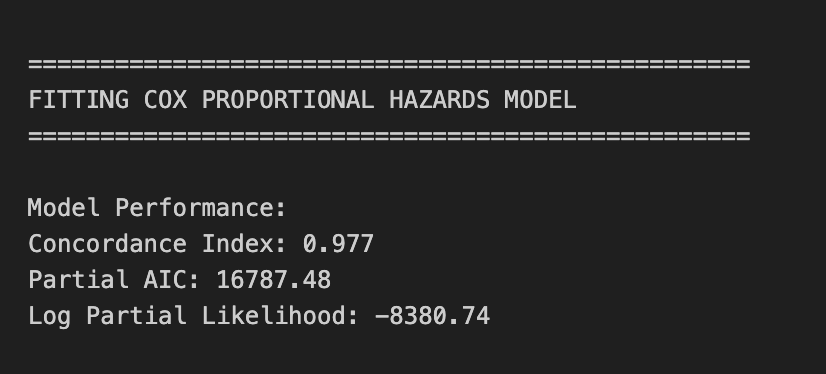

In [143]:
# 6. Model Validation
test_predictions = cph.predict_partial_hazard(test_data)
test_c_index = concordance_index(test_data['Tenure'], 
                                -test_predictions, 
                                test_data['Exited_1'])
print(f"Test C-index: {test_c_index:.3f}")

# 7. Individual Predictions
print("\n" + "="*50)
print("INDIVIDUAL PREDICTIONS")
print("="*50)

Test C-index: 0.781

INDIVIDUAL PREDICTIONS


In [145]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,EstimatedSalary,CreditScore_log,Age_log,...,EstimatedSalary_log,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1,IsActiveMember_1,Exited_1,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,Hargrave,619,42,2,0.00,101348.88,6.429719,3.761200,...,11.526334,False,False,False,True,True,True,False,False,False
1,2,15647311,Hill,608,41,1,83807.86,112542.58,6.411818,3.737670,...,11.631096,False,False,False,False,True,False,False,True,False
2,3,15619304,Onio,502,42,8,159660.80,113931.57,6.220590,3.761200,...,11.643362,False,True,False,True,False,True,False,False,False
3,4,15701354,Boni,699,39,1,0.00,93826.63,6.551080,3.688879,...,11.449215,True,False,False,False,False,False,False,False,False
4,5,15737888,Mitchell,850,43,2,125510.82,79084.10,6.746412,3.784190,...,11.278280,False,False,False,True,True,False,False,True,False


## Predict active customers

In [147]:
active_customers = df[df['Exited_1'] == False]

In [165]:
# predict risk score
risk_scores = cph.predict_partial_hazard(active_customers[feature_cols])

# median_survival_time
median_survival = cph.predict_median(active_customers[feature_cols])

# churn_0year

surv_funcs = cph.predict_survival_function(active_customers[feature_cols])
surv_funcs_below1year = surv_funcs.loc[0]

# churn_90d
surv_funcs_5years = surv_funcs.loc[5]

# churn_90%
churn_70_per = []
threshold = 0.3
for i in range(active_customers.shape[0]):
        surv = surv_funcs.iloc[:, i]
        t = surv[surv <= threshold].index.min()
        churn_70_per.append(t if pd.notna(t) else np.nan)




In [175]:
new_data = pd.DataFrame({
    'customer_name': active_customers['Surname'],
    'risk_score': risk_scores,
    'median_survival_time': median_survival,
    'live_0year': surv_funcs_below1year,
    'live_5years': surv_funcs_5years,
    'churn_70%': churn_70_per,
    'salary': active_customers['EstimatedSalary'],
    'gender': active_customers['Gender_Male'].apply(lambda x: 'Male' if x == 1 else 'Female')
    
})

new_data.head()

,customer_name,risk_score,median_survival_time,live_0year,live_5years,churn_70%,salary,gender
1,Hill,1.587146,inf,0.990462,0.856015,NaN,112542.58,Female
3,Boni,0.810767,inf,0.995116,0.923654,NaN,93826.63,Female
4,Mitchell,1.574294,inf,0.990539,0.857094,NaN,79084.10,Female
6,Bartlett,0.486987,inf,0.997064,0.953418,NaN,10062.80,Male
8,He,0.365999,inf,0.997792,0.964784,NaN,74940.50,Male


In [176]:
new_data.describe()

,risk_score,median_survival_time,live_0year,live_5years,churn_70%,salary
count,7963.000000,7963.0,7963.000000,7963.000000,503.000000,7963.000000
mean,1.119860,inf,0.993282,0.900795,9.461233,99738.391772
std,1.097236,NaN,0.006515,0.084253,0.864292,57405.586966
min,0.065017,3.0,0.911134,0.220986,5.000000,90.070000
25%,0.427232,NaN,0.991399,0.869249,9.000000,50783.490000
50%,0.763878,NaN,0.995398,0.927906,10.000000,99645.040000
75%,1.430522,NaN,0.997423,0.959015,10.000000,148609.955000
max,15.411890,inf,0.999607,0.993652,10.000000,199992.480000


In [177]:
new_data.sort_values(by='risk_score', ascending = False).head(10)

,customer_name,risk_score,median_survival_time,live_0year,live_5years,churn_70%,salary,gender
9587,Norriss,15.411890,3.0,0.911134,0.220986,5.0,176244.87,Female
4815,Obioma,15.401671,3.0,0.911191,0.221208,5.0,37836.64,Female
5465,Chibueze,11.644055,4.0,0.932102,0.319633,6.0,189159.97,Female
8156,Mayrhofer,11.144719,4.0,0.934917,0.335656,6.0,125848.88,Male
4501,Kelly,11.041876,4.0,0.935498,0.339054,6.0,123304.62,Female
7692,Wood,10.871822,4.0,0.936459,0.344749,6.0,10078.02,Male
6763,Chung,10.665901,4.0,0.937624,0.351774,6.0,82782.08,Female
1614,Sopuluchi,10.442957,4.0,0.938887,0.359541,6.0,81514.06,Male
8188,Tucker,10.205231,4.0,0.940236,0.368011,6.0,78365.75,Female
313,Skinner,8.977797,5.0,0.947231,0.415028,7.0,182822.50,Female
